In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from stop_words import get_stop_words
import copy
sns.set()
%matplotlib inline 

# Tarea 4: Busqueda de imagenes
Integrantes : Francisco Muñoz y Patricio Lopez


### Descripcion del problema:
Crear un buscador de imagenes que utilice textos y encuentre las imagenes que mejor coinciden con el contenido del texto.

### Herramientas disponibles:
* Conjunto de imagenes sacadas del dataset de COCO, teniendo para cada una:
    * un vector de caracteristicas con tamaño 2048
    * 5 ejemplos de captions (texto) que se relacionen con dicha imagen
* Libre uso de librerias python en tanto sean codigo libre

### Solucion planteada:
Primero es necesario obtener la informacion relevante de cada caption y traducirla a algun formato vectorial, con lo cual se planea entrenar un regresor que entregue una prediccion del vector de caracteristicas correspondiente al texto. Luego, para cada nueva consulta, basta con regresionar el vector de caracteristicas y realizar un similarity-search para obtener la imagen que mejor coincida.

El objetivo de esta tarea (y este notebook) es mostrar este procedimiento y realizar todas las validaciones y experimentos necesarios para asegurar que el procedimiento planteado puede ser efectivamente aplicado para buscar imagenes.

### Estructura del notebook:
Los pasos realizados durante esta tarea son:
* [Construccion del regressor](#Creacion-de-un-Regresor): Se explica como se construye el regressor utilizado y se muestra un ejemplo de su entrenamiento y el como se verifica que es un buen modelo (sin overfitting ni underfitting)
* [Casos de estudio](#Casos-de-estudio): Se presentan los 6 casos de estudio que seran utilizados para realizar los experimentos, especificando los metodos que se utilizaran para obtener los descriptores de texto. Aqui se cargan sus regresores y se muestra que ninguno de ellos tiene overffiting
* [Experimentos](#Experimentos): Se cargan los dataset de prueba (A, B, C), se obtienen sus descriptores de texto para cada experimento y se realizan las similarity search
* [Resultados y analisis](#Resultados-y-Analisis): Se obtienen una serie de indicadores en base a los resultados del similarity search, luego se muestran y analisan estos resultados.
* [Ejemplos practicos](#Ejemplo-practico:-Buscando-una-imagen): se muestran algunos ejemplos de los resultados obtenidos, donde se introduce un texto y se muestra las imagenes que mejor coinciden con el texto buscado
* [#Conclusiones finales](#Conclusiones-finales): Por ultimo se concluye sobre los resultados obtenidos, combinando con la teoria y chequeando si se cumplieron los comportamientos esperados.

## Regresor: NN utilizando keras
Para realizar la regresion lineal que entrege los vectores de caracteristicas de una imagen buscada, se utiliza la libreria keras. Con esta libreria, se define una red MLP donde la ultima capa no aplique ningun activador ni un soft-max. Para simplificar el contenido de este notebook, hemos implementado nuestro regresor en una libreria a parte, desde la cual importamos lo siguiente:

In [6]:
from src.regressor import Regressor, r_square, rmse

Using TensorFlow backend.


Es posible ver los metodos definidos dentro al utilizar la funcion python help o accediendo directamente a la carpeta contenedora del codigo que sera adjuntada con la entrega.

Para agilizar el proceso, todos los regresores que se utilizaran en la obtencion de los indicadores seran cargados desde disco. Pero a continuacion mostraremos el procedimiento necesario para entrenar un nuevo modelo, incluyendo la verificacion de overfitting y el guardar el modelo resultante a disco.

### Calculo de los descriptores de texto
El primer paso es obtener los vectores que describen cada una de las 100000 frases contenidas en el set de entrenamiento. Se implementan dos alternativas para este procedimiento:
* CountVectorizer: Separa el texto en tokens y realiza una cuenta sobre las repeticiones para obtener un vocabulario y asi generar los descriptores de texto. Tambien implementa ngram para incrementar el tamaño del vector y stop-words para evitar palabras innecesarias.
* TF-IDF: ...

Ambas alternativas deben ser configuradas por medio de una serie de parametros. Varias estos parametros sera priordial al momento de entrenar distintos Regressores.

Nuevamente, todo el codigo relativo a esta implementacion es creada en un codigo python externo a este notebook y debe ser importado de la siguiente manera:

In [7]:
from src.filehandler import DataHandler

#### Cargando los datos de entrenamiento
En esta seccion, se creara un Regresor utilizando TF-IDF como generador de vectores. La configuracion a utilizar sera:
* ngram-range = (1, 3)
* stop-words = spanish

In [8]:
stop_words = get_stop_words('spanish')
# debemos indicar el directorio que contiene los datos y los sub-directorios que contienen cada dataset
data = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
# y obtenemos nuestros vectores
X_train, X_test, y_train, y_test = data.get_data(method="tf-idf", stop_words=stop_words, ngram_range=(1, 3), verbose=False)
print("shapes")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

shapes
X_train: (100000, 640)
y_train: (100000, 2048)
X_test: (5000, 640)
y_test: (5000, 2048)


#### creando el regresor
Luego creamos un regressor para este tamaño de vectores, con dos capas escondidas, cada una de 200 neuronas. La red MLP tendra la siguiente configuracion:
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True


Adicionalmente, se implementa un Early Stopping con una paciencia de 4 epocas y que monitorea el loss de validacion, de forma que cuando deje de decrecer o empiece a aumentar, detenga el entrenamiento y evite un overfitting. Ademas, se monitorea la metrica de MAE (mean absolute error), RMSE (root mean square error) y R-square.

In [112]:
in_dim = X_train.shape[1]
out_dim = y_train.shape[1]
reg = Regressor(input_dim=in_dim, output_dim=out_dim, n=2, layer_size=200, 
                loss='mean_squared_error', optimizer='adam', metrics=['mae', rmse, r_square])
reg.build()
history = reg.fit(X_train, y_train, epochs=100, batch_size=200, validation_split=0.2, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               128200    
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              411648    
Total params: 580,048
Trainable params: 580,048
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 6s 73us/step - loss: 0.6444 - mean_absolute_error: 0.4867 - rmse: 0.7909 - r_square: 0.1227 - val_loss: 0.5650 - val_mean_absolute_error: 0.4599 - val_rmse: 0.7402 - val_r_square: 0.2323
Epoch 2/100
80000/80000 [==============================] - 6s 70us/step - loss: 0.5453 - mean_absolute_e

#### Probando el regressor y validando resultados
Como se observa al ejecutar la celda de arriba, entrenar el modelo entrega informacion sobre las metricas al terminar cada epoca y se detiene cuando el loss de validacion deja de bajar. Es posible evaluar el modelo en un nuevo dataset u obtener la historia de las metricas sobre el dataset de entrenamiento y validacion. Con esto ultimo se puede visualizar que el resultado no contiene ni overfitting ni underfitting dado que las curvas en ambos dataset se mantienen juntas.

evaluando test
5000/5000 [==============================] - 0s 45us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.71
r_square: 0.30


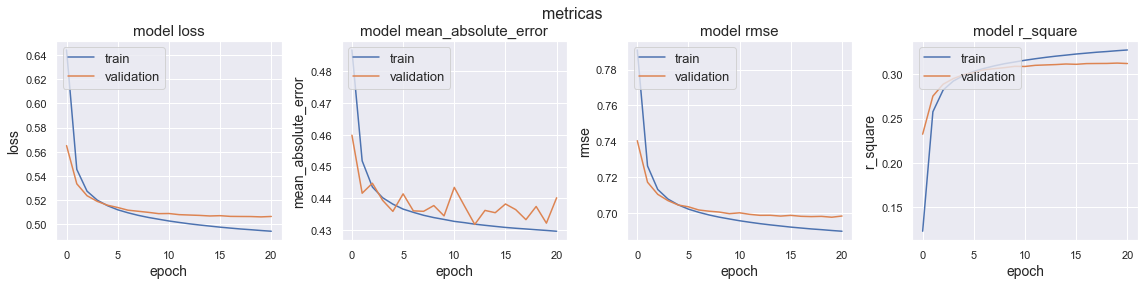

In [113]:
# graficar las metricas
reg.plot_metrics()

# evaluar el modelo
scores = reg.evaluate(X_test, y_test)

#### Guardando el regressor
Por ultimo, el modelo debe ser guardado si se desea utilizarlo para situaciones posteriores, esto se realiza muy facilmente de la siguiente forma:

saving model to disk ... done!
loading model from disk ... done!
evaluando test
5000/5000 [==============================] - 0s 67us/step
    EVALUATION RESULTS :  
loss: 0.52
mean_absolute_error: 0.44
rmse: 0.71
r_square: 0.30


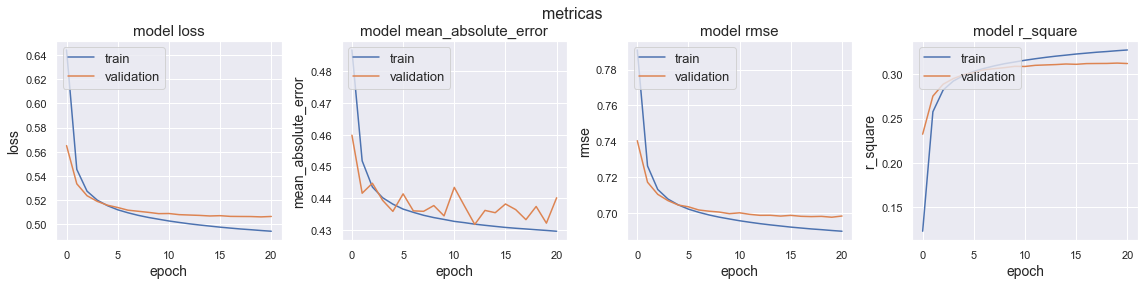

In [114]:
reg.save("test")
# se puede verificar esto al cargar el modelo en una nueva variable
reg2 = Regressor()
reg2.load("test", custom_objects={"rmse": rmse, "r_square": r_square})
# y veamos que evaluar el conjunto de test da los mismos resultados
score2 = reg2.evaluate(X_test, y_test)

# graficar las metricas
metrics = reg2.plot_metrics()

### Casos de estudio
Para este trabajo se opto por fijar una arquitectura para el regresor y estudiar diversas configuraciones en la obtencion de los descriptores de texto. La arquitectura comun para todos los casos de estudio sera la misma que fue utilizada en el ejemplo de arriba, en particular:

* capas internas:
    * fully-connected de 200 neuronas con activador ReLu
    * fully-connected de 200 neuronas con activador ReLu
* capa de salida: fully-connected de 2048 sin activador
* batch-size = 200
* loss = mean square error (MSE)
* optimizer = ADAM
* max-epochs = 100
* validation-split = 20%
* shufle = True
* Early Stopping : tolerancia de 0.005, con una paciencia de 4 epochas
* metricas monitoreadas : Mean Absolute Error, Root Mean Square Error, R-Square


Luego, los casos de estudio seran:

* Count-vectorizer con ngram_range = (1,1) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y sin stop_words
* Count-vectorizer con ngram_range = (1,4) y con stop_words de español
* TF-IDF con ngram_range = (1,1) y sin stop_words
* TF-IDF con ngram_range = (1,4) y sin stop_words
* TF-IDF con ngram_range = (1,4) y con stop_words de español

Los regresores para cada uno de estos modelos se encuentran almacenados en la carpeta /model con nombres descriptivos de cada configuracion, de forma que puedan ser cargados facilmente.

A continuacion se presentan graficos de cada uno de estos regressores para asegurar que ninguno de ellos presente overffiting.

cargando, evaluando y graficando regresores para 6 experimentos: ...... Done!


,MSE,MAE,RMSE,R2
cv_ngram11_none,0.514907,0.437129,0.704303,0.299002
cv_ngram14_none,0.520575,0.440264,0.708411,0.290992
cv_ngram14_stop_words,0.515872,0.439397,0.705112,0.297643
tf_idf_ngram11_none,0.514989,0.432423,0.704085,0.298931
tf_idf_ngram14_none,0.516810,0.443114,0.706048,0.296064
tf_idf_ngram14_stop_words,0.515313,0.438198,0.704616,0.298323


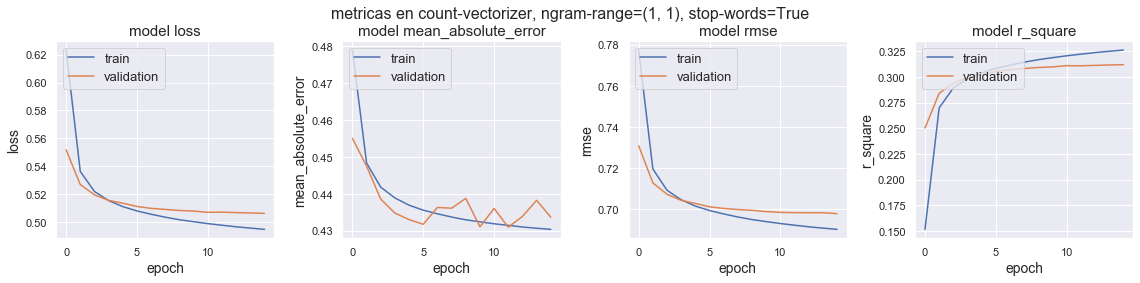

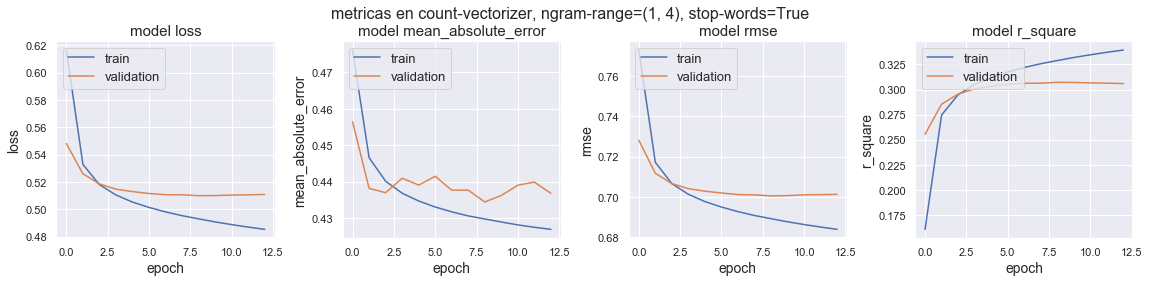

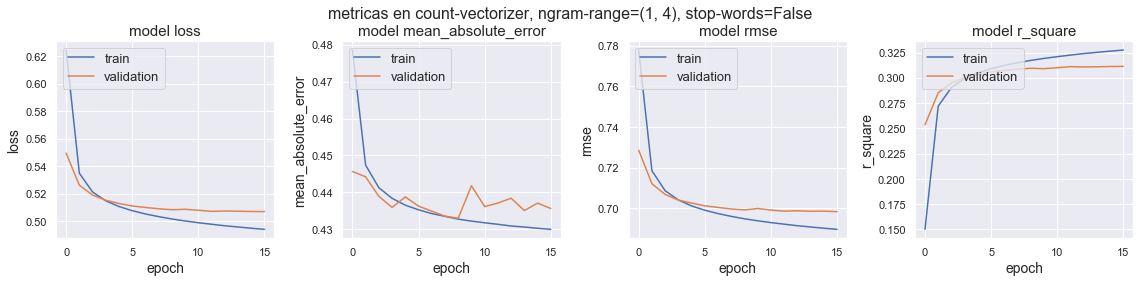

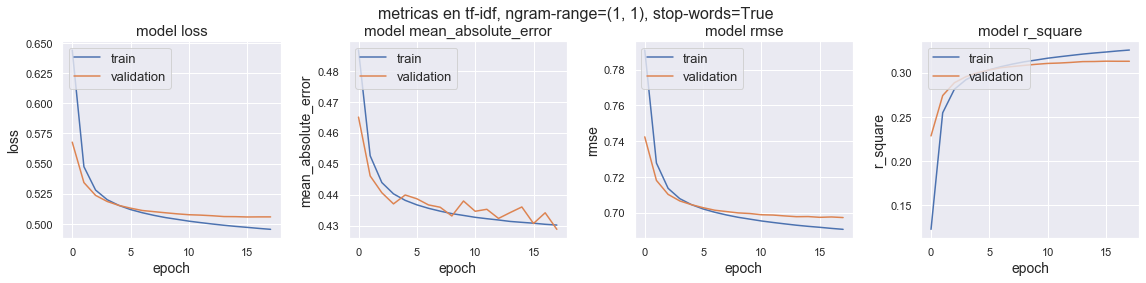

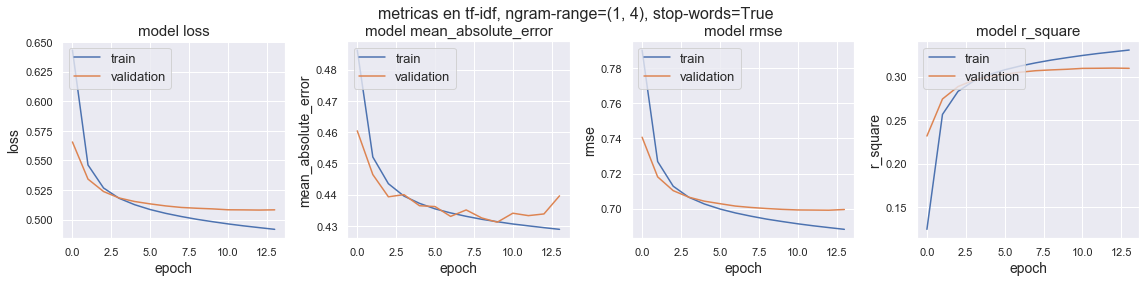

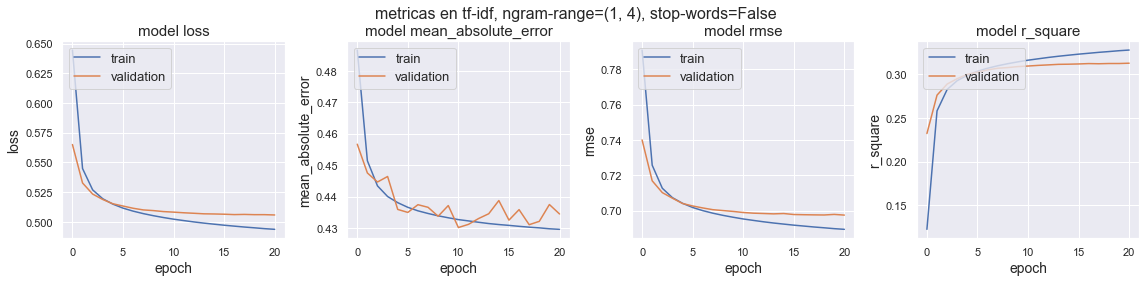

In [11]:
# ========= global variables for the experiments ==============
stop_words = get_stop_words('spanish')
methods = ["count-vectorizer"] * 3 + ["tf-idf"] * 3
ngram_ranges = [(1, 1), (1, 4), (1, 4)] * 3
stop_words_list = ([None] * 2 + [stop_words]) * 2
models = ["cv_ngram11_none", "cv_ngram14_none", "cv_ngram14_stop_words",
          "tf_idf_ngram11_none", "tf_idf_ngram14_none", "tf_idf_ngram14_stop_words"]
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")
# ====================================================================

def get_regressors(data):
    regs = []
    metrics = {}
    print("cargando, evaluando y graficando regresores para 6 experimentos: ", end="")
    for method, model, ngram_range, sw in zip(methods, models, ngram_ranges, stop_words_list):
        reg = Regressor()
        X_train, X_test, y_train, y_test = data.get_data(method=method, stop_words=sw, 
                                                         ngram_range=ngram_range, verbose=False)
        reg.load(model, custom_objects={"rmse": rmse, "r_square": r_square}, verbose=False)
        reg.plot_metrics("metricas en {}, ngram-range=({}, {}), stop-words={}".format(method, ngram_range[0],
                                                                                      ngram_range[1], (not sw)))
        scores = reg.evaluate(X_test, y_test, verbose=False)
        metrics[model] = scores
        regs.append(reg)
        print(".", end="")
    print(" Done!")
    return regs, metrics
regs, metrics = get_regressors(data_A)
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["MSE", "MAE", "RMSE", "R2"])
df
# reg1 = Regressor()
# reg2 = Regressor()
# reg3 = Regressor()
# reg4 = Regressor()
# reg5 = Regressor()
# reg6 = Regressor()
# reg1.load("cv_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg1.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 1)")
# reg2.load("cv_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg2.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4)")
# reg3.load("cv_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg3.plot_metrics("metricas en Count-Vectorizer, ngram-range=(1, 4), con stop_words")
# reg4.load("tf_idf_ngram11_none", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg4.plot_metrics("metricas en TF-IDF, ngram-range=(1, 1)")
# reg5.load("tf_idf_ngram14_none", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg5.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4)")
# reg6.load("tf_idf_ngram14_stop_words", custom_objects={"rmse": rmse, "r_square": r_square})
# metrics = reg6.plot_metrics("metricas en TF-IDF, ngram-range=(1, 4), con stop_words")

Donde se observa que el loss del set de validacion siempre se mantiene cercano al loss de entrenamiento, caracteristica crucial para evitar el overfitting. Se presentan adicionalmente otras metricas utilizadas en regressiones (RMSE, MAE, R2) y todas siempre se mantienen similares para entrenamiento y validacion. Todo esto sugiere claramente que se han entrenado los regresores correctamente.

### Experimentos

Para estudiar los resultados obtenidos por la regresión vamos a calcular varias métricas más, las que son:
* Silimarity search, busqueda de los más cercanos. Para los 5000 vectores de test se guardan
  las posiciones de los 1000 vectores más cercanos, de 1000 vectores, lo que se traduce en un
  ordenamiento de las predicciones segun distancia entre el descriptor de texto y el de imagen.
* Un vector de posiciones correctas, para cada descriptor de texto se calcula donde está ubicada
  la respuesta correcta dada la matriz obtenida en similarity search, serian 5000 números entre
  el 1 y el 1000. Con esto se muestra un histograma para visualizar mejor la frecuencia de las posiciones.
* Recall@k, que correspode al porcentaje de esos 5000 números que son menores o iguales a K.
  Especificamente se calcula recall@1, recall@5 y recall@10.
* MRR o mean reciprocal rank
* Posición promedio del vector de posiciones correctas.


In [12]:
# funciones utiles
import src.utils as utils
#cargar medidor de indicadores para Similarity search, recall at k, MRR y Mean
from src.indicators import Indicators
ind = Indicators()

#### Crear descriptores de texto para los test propuestos

Primero cargamos los datos necesarios para calcular los descriptores de texto, para los 6 test
descritos más arriba.

In [13]:
stop_words = get_stop_words('spanish')
data_A = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_A_data")
data_B = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_B_data")
data_C = DataHandler(root_folder="./data", train_folder="/train_data", test_folder="/test_C_data")

X_tests = []
def get_X_tests(data):
    methods = ["count-vectorizer"] * 3 + ["tf-idf"] * 3
    ngram_ranges = [(1, 1), (1, 4), (1, 4)] * 3
    stop_words_list = ([None] * 2 + [stop_words]) * 2
    X_tests = []
    print("cargando datos y obteniendo descriptores de texto para 6 experimentos: ", end="")
    for method, ngram_range, sw in zip(methods, ngram_ranges, stop_words_list):
        X_tests.append(data.get_data_test(method=method, stop_words=sw, ngram_range=ngram_range, verbose=False))
        print(".", end="")
    print(" Done!")
    return X_tests
X_tests = get_X_tests(data_A)
# X_test1= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,1), verbose=False)
# X_test2= data_A.get_data_test(method="count-vectorizer", stop_words=None, ngram_range=(1,4), verbose=False)
# X_test3= data_A.get_data_test(method="count-vectorizer", stop_words=stop_words, ngram_range=(1,4), verbose=False)
# X_test4= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,1), verbose=False)
# X_test5= data_A.get_data_test(method="tf-idf", stop_words=None, ngram_range=(1,4), verbose=False)
# X_test6= data_A.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4), verbose=False)

cargando datos y obteniendo descriptores de texto para 6 experimentos: ...... Done!


#### Calcular indicadores

Calculamos los vectores resultantes de evaluar los test en las regresiones, y se cargan tambien los descriptores de imagen de largo 1000, para hacer luego el similarity search.

In [14]:
#calculamos los vectores resultantes del predict para cada test
def get_vectors(regs, X_tests):
    vectores = []
    print("obteniendo vectores predichos por cada red para los 6 experimentos: ", end="")
    for reg, X_test in zip(regs, X_tests):
        vectores.append(reg.predict(X_test))
        print(".", end="")
    print(" Done!")
    return vectores

vectores = get_vectors(regs, X_tests)
# vectores_1 = reg1.predict(X_test1)
# vectores_2 = reg2.predict(X_test2)
# vectores_3 = reg3.predict(X_test3)
# vectores_4 = reg4.predict(X_test4)
# vectores_5 = reg5.predict(X_test5)
# vectores_6 = reg6.predict(X_test6)
#cargamos los descriptores de imagenes
y_simple_test_A = data_A.load_simple_test("A", verbose=False) #este es el que usaremos a priori
#los test B y C se usaran para hacer una validacion final para ver si hay overfitting
y_simple_test_B = data_B.load_simple_test("B", verbose=False)
y_simple_test_C = data_C.load_simple_test("C", verbose=False)

obteniendo vectores predichos por cada red para los 6 experimentos: ...... Done!


In [15]:
def get_ranks_data(test_data, vectors):
    print("::::::::::::::::: obteniendo los ranks para cada experimento :::::::::::::::::::::::")
    print(":::::::::::::::::         se utiliza multiprocessing         :::::::::::::::::::::::")
    ranks = []
    data = []
    for vector in vectors:
        ranks.append(ind.similarity_search(test_data, vector, verbose=False))
        data.append(ind.get_formated_data())
    print("::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::")
    return ranks, data
ranks, results = get_ranks_data(y_simple_test_A, vectores)
# rank_1 = ind.similarity_search(y_simple_test_A, vectores_1)
# datos_1 = ind.get_formated_data()
# rank_2 = ind.similarity_search(y_simple_test_A, vectores_2)
# datos_2 = ind.get_formated_data()
# rank_3 = ind.similarity_search(y_simple_test_A, vectores_3)
# datos_3 = ind.get_formated_data()
# rank_4 = ind.similarity_search(y_simple_test_A, vectores_4)
# datos_4 = ind.get_formated_data()
# rank_5 = ind.similarity_search(y_simple_test_A, vectores_5)
# datos_5 = ind.get_formated_data()
# rank_6 = ind.similarity_search(y_simple_test_A, vectores_6)
# datos_6 = ind.get_formated_data()

::::::::::::::::: obteniendo los ranks para cada experimento :::::::::::::::::::::::
:::::::::::::::::         se utiliza multiprocessing         :::::::::::::::::::::::
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 37.908]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 37.575]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 37.355]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 37.051]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 37.999]
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 38.053]
::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::


### Resultados y Analisis

Luego de calculados los vectores de posiciones, se grafican sus respectivos histogramas y una tabla con las metricas mencionadas anteriormente.

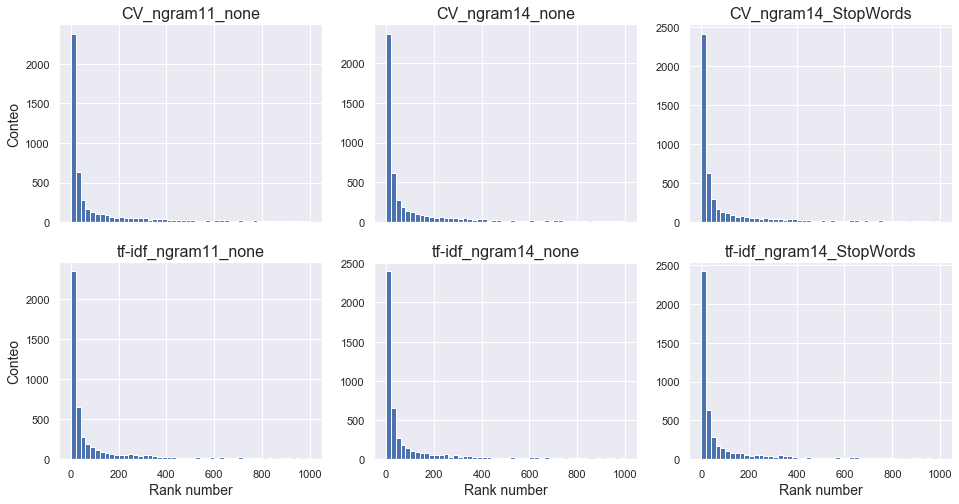

In [46]:
labels = ['recall@1','recall@5','recall@10','MRR','Mean', "MSE", "MAE", "RMSE", "R2"]
index = ['CV_ngram11_none', 'CV_ngram14_none','CV_ngram14_StopWords',
         'tf-idf_ngram11_none', 'tf-idf_ngram14_none','tf-idf_ngram14_StopWords']
def mix_data(result_exp, metrics, keys):
    results_copy = copy.deepcopy(result_exp)
    table_Data = []
    for i, k in enumerate(keys):
        table_data.append(results_copy[i])
        table_data[-1].extend(metrics[k])
    return table_data

def plot_hists(ranks, index):
    fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex=True)
    for i in range(6):
        j = i % 3
        k = 1 if i >= 3 else 0
        ax[k][j].hist(ranks[i], 50)
        ax[k][j].set_title(index[i], fontsize=16)
        if j == 0:
            ax[k][j].set_ylabel("Conteo", fontsize=14)
        if k == 1:
            ax[k][j].set_xlabel("Rank number", fontsize=14)
table_data = []
table_data = mix_data(results, metrics, models)
tabla = utils.get_table(table_data, index, labels)
plot_hists(ranks, index)

#### Tabla resumen de experimentos para el dataset de test A

In [49]:
tabla

,recall@1,recall@5,recall@10,MRR,Mean,MSE,MAE,RMSE,R2
CV_ngram11_none,0.0600,0.2192,0.3416,0.147287,123.0534,0.514907,0.437129,0.704303,0.299002
CV_ngram14_none,0.0636,0.2266,0.3402,0.150460,119.7922,0.520575,0.440264,0.708411,0.290992
CV_ngram14_StopWords,0.0652,0.2228,0.3458,0.152514,119.9920,0.515872,0.439397,0.705112,0.297643
tf-idf_ngram11_none,0.0644,0.2208,0.3376,0.149207,122.3534,0.514989,0.432423,0.704085,0.298931
tf-idf_ngram14_none,0.0678,0.2246,0.3464,0.153862,118.4948,0.516810,0.443114,0.706048,0.296064
tf-idf_ngram14_StopWords,0.0692,0.2248,0.3450,0.155181,119.1726,0.515313,0.438198,0.704616,0.298323


#### Analisis

Se observa que todos los experimentos tienen metricas muy parecidas, pero el que tiene las mejores métricas en general es el TF-IDF con ngram_range = (1,4) y con stop_words de español. Entonces probaremos con los test B y C para ver si tienen metricas similares tambien.

In [109]:
def get_for_dataset(dataset, reg, y_simple_test):
    print(":::::: TEST SET ADICIONAL :::::::::::")
    print("~ obteniendo datos")
    X_test= dataset.get_data_test(method="tf-idf", stop_words=stop_words, ngram_range=(1,4), verbose=False)
    _, X_test_full, _, y_test_full = dataset.get_data(method="tf-idf", stop_words=stop_words, 
                                                   ngram_range=(1,4), verbose=False)
    print("~ pasando datos por el regresor")
    vectores = reg.predict(X_test)
    scores_test = reg.evaluate(X_test_full, y_test_full, verbose=False)
    print("~ realizando busquedas y obteniendo indicadores (usando multiprocessing)")
    rank_test = ind.similarity_search(y_simple_test, vectores, verbose=False)
    datos_test = ind.get_formated_data()
    datos_test.extend(scores_test)
    return datos_test, rank_test
    
datos_test_B, rank_test_B = get_for_dataset(data_B, regs[5], y_simple_test_B)
datos_test_C, rank_test_C = get_for_dataset(data_B, regs[5], y_simple_test_B)
datos_test_A = table_data[5]
rank_test_A = ranks[5]

:::::: TEST SET ADICIONAL :::::::::::
~ obteniendo datos
~ pasando datos por el regresor
~ realizando busquedas y obteniendo indicadores (usando multiprocessing)
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 42.66]
:::::: TEST SET ADICIONAL :::::::::::
~ obteniendo datos
~ pasando datos por el regresor
~ realizando busquedas y obteniendo indicadores (usando multiprocessing)
-> launching 6 jobs: ...... DONE! || waiting 6 jobs: ...... DONE! || grouping data --- DONE! [elapse time: 39.551]


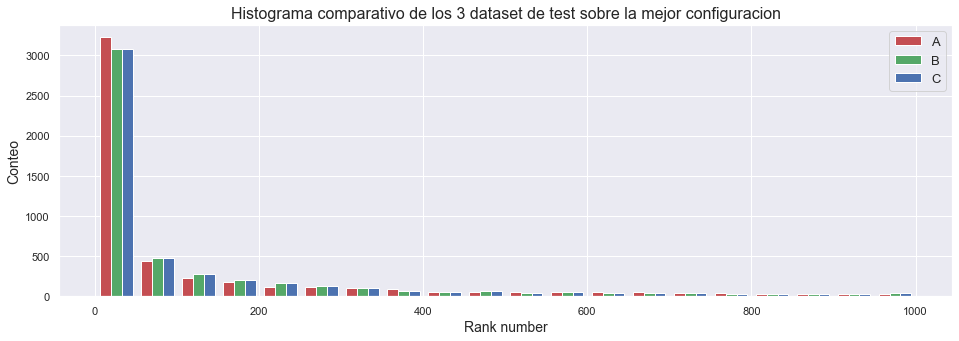

In [110]:
plt.figure(figsize=(16, 5))
kde = False
bins = 20
plt.hist([rank_test_A, rank_test_B, rank_test_C], bins, histtype='bar', color=["r", "g", "b"], label=["A", "B", "C"])
plt.legend(fontsize=13)
plt.xlabel("Rank number", fontsize=14)
plt.ylabel("Conteo", fontsize=14)
_ = plt.title("Histograma comparativo de los 3 dataset de test sobre la mejor configuracion", fontsize=16)

In [111]:
index = ['Test_A', 'Test_B','Test_C']
datos = [datos_test_A, datos_test_B, datos_test_C]
tabla = utils.get_table(datos, index, labels)
tabla

,recall@1,recall@5,recall@10,MRR,Mean,MSE,MAE,RMSE,R2
Test_A,0.0692,0.2248,0.3450,0.155181,119.1726,0.515313,0.438198,0.704616,0.298323
Test_B,0.0732,0.2348,0.3498,0.157697,120.7294,0.520663,0.441791,0.707988,0.291125
Test_C,0.0732,0.2348,0.3498,0.157697,120.7294,0.520663,0.441791,0.707988,0.291125


### Ejemplo practico: Buscando una imagen

### Conclusiones finales